In [7]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix

np.random.seed(412)  # For reproducibility
from scipy.sparse import csc_matrix, csr_matrix

## Exercise 1)

In [3]:
#Loading data


def load_data(file_path):
    """Loads the data matrix X and target vector y from a CSV file"""
   
    # load data
    csv_data = pd.read_csv(file_path)
    print(f"Data features: \n {csv_data.columns.values} \n")

    # Separate features (X) and target (y)
    X = csv_data.iloc[:, :-1].values
    y = csv_data.iloc[:, -1].values

    print(y[2])

    num_ones_or_zeros_y=len(y[y == 0])+len(y[y==1])
    
    print(f"The # of ones and zeros: {num_ones_or_zeros_y} is the same as length of y {y.shape[0]}")


    # Convert y to ±1 (y is in {0, 1})
    y = np.where(y == 0, -1,1)

    return X, y


# Load the dataset
X, y = load_data('data.csv')
print(X.shape)

Data features: 
 ['android.permission.GET_ACCOUNTS'
 'com.sonyericsson.home.permission.BROADCAST_BADGE'
 'android.permission.READ_PROFILE' 'android.permission.MANAGE_ACCOUNTS'
 'android.permission.WRITE_SYNC_SETTINGS'
 'android.permission.READ_EXTERNAL_STORAGE'
 'android.permission.RECEIVE_SMS'
 'com.android.launcher.permission.READ_SETTINGS'
 'android.permission.WRITE_SETTINGS'
 'com.google.android.providers.gsf.permission.READ_GSERVICES'
 'android.permission.DOWNLOAD_WITHOUT_NOTIFICATION'
 'android.permission.GET_TASKS'
 'android.permission.WRITE_EXTERNAL_STORAGE'
 'android.permission.RECORD_AUDIO'
 'com.huawei.android.launcher.permission.CHANGE_BADGE'
 'com.oppo.launcher.permission.READ_SETTINGS'
 'android.permission.CHANGE_NETWORK_STATE'
 'com.android.launcher.permission.INSTALL_SHORTCUT'
 'android.permission.android.permission.READ_PHONE_STATE'
 'android.permission.CALL_PHONE' 'android.permission.WRITE_CONTACTS'
 'android.permission.READ_PHONE_STATE'
 'com.samsung.android.provider

In [4]:
# Display data details
print(f"Loaded dataset with {X.shape[0]} samples and {X.shape[1]} features.")
print(f"Number of malicious data points: {np.sum(y == 1)}")
print(f"Number of non-malicious data points: {np.sum(y == -1)}")

sparsity = len(X[X == 0]) / X.size * 100
print(f"{sparsity:.2f}% of X's entries are 0")


Loaded dataset with 29332 samples and 86 features.
Number of malicious data points: 14700
Number of non-malicious data points: 14632
89.01% of X's entries are 0


We dont need one hot encoding since all the data is binary. the data features and many others, are binary features. Each permission is either granted (1) or not granted (0).

## Exercise 2)

In [5]:
## Create test and training sets



def split_data(X, y, r=0.5):
    """
    Splits the data into training and test sets.
    X should be in CSC (Compressed Sparse Column) format.
    y will be returned as a dense vector.
    r: Test size ratio (0 < r < 1).
    """
    # Convert X to sparse CSC matrix (if not already sparse)
    if not isinstance(X, csc_matrix):
        X_sparse = csc_matrix(X)
    else:
        X_sparse = X
    
    # y is now expected to be a dense array, so no need to convert it to sparse
    y_dense = np.array(y)

    # Shuffle and split data
    indices = np.random.permutation(X_sparse.shape[0])
    split_index = int(X_sparse.shape[0] * (1 - r))

    # Splitting X
    X_train = X_sparse[indices[:split_index], :]
    X_test = X_sparse[indices[split_index:], :]
    
    # Splitting y (kept as dense)
    y_train = y_dense[indices[:split_index]]
    y_test = y_dense[indices[split_index:]]

    return X_train, X_test, y_train, y_test


# Split the dataset (50/50 split)
X_train, X_test, y_train, y_test = split_data(X, y, r=0.5)

## Exercise 3)

In [6]:
import numpy as np


def classify(X, y, w):
    """Returns the number of correctly classified points using the weight vector w."""
    # Perform matrix-vector multiplication (X.dot(w)) and predict using the sign function
    predictions = np.sign(X.dot(w))
    
    # Convert sparse vector y to dense for comparison
    if isinstance(y, np.ndarray):  # If y is already dense
        y_dense = y
    else:
        y_dense = y.toarray().flatten()  # Convert sparse matrix to dense and flatten it
    
    # Compare predictions with true labels and count correct classifications
    correct = np.sum(predictions == y_dense)
    accuracy = correct / len(y_dense)
    
    return correct, accuracy

# Example: Try random weight vector
w_random = np.random.randn(X_train.shape[1])  # Random weight vector of appropriate size
correct, accuracy = classify(X_test, y_test, w_random)
print(f"Random classification accuracy: {accuracy * 100:.2f}%")


Random classification accuracy: 69.68%


Gradient for logistic regression

The gradient of the logistic regression cost function with respect to \( w \) is:

$
\frac{\partial J(w)}{\partial w} = \frac{1}{m} X^T \left( \sigma(Xw) - y \right) + \frac{\lambda}{m} w
$

Where:
- $\sigma(z)$ is the **sigmoid function**:

$
\sigma(z) = \frac{1}{1 + e^{-z}}
$

- $ X $ is the matrix of input features.
- $ y $ is the vector of target labels.
- $ w $ is the weight vector.
- $ \lambda $ is the regularization constant.
- $ m $ is the number of training examples.
## Exercise 5)


$
\frac{\partial J(W)}{\partial w_j} = \sum_{i=1}^{n} L(y_i, x_i^T w)
$


In [ ]:
def sigmoid(z):
    """Sigmoid function."""
    return 1 / (1 + np.exp(-z))

X = X_train
y = y_train

num_steps = 1000
alpha = 0.01
reg_lambda = 10
w = np.zeros(X.shape[1])
for step in range(num_steps):
    big_sigma = sigmoid(X.dot(w) * y)
    B = (big_sigma - 1) * y
    grad = B.dot(X)
    grad += reg_lambda * w
    w -= alpha * grad



correct, accuracy = classify(X_test, y_test, w)
print(f"Test set classification accuracy: {accuracy * 100:.2f}%")
cost = -np.sum( np.log(big_sigma) ) + 0.5*reg_lambda * w.dot(w)
cost / len(y)


In [ ]:

def sigmoid(z):
    """Sigmoid function."""
    return 1 / (1 + np.exp(-z))



def logistic_regression_cost_grad(X, y, w, reg_lambda):
    """Calculates the cost and gradient for logistic regression."""
    m = len(y)
    z = X.dot(w)
    # z= np.dot(X,w)
    h = sigmoid(z)

    # print("debug")
    # print(np.dot(X,w))


    # Cost function with regularization
    cost = (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) + (reg_lambda / (2 * m)) * np.dot(w, w)
    cost = (-1 / m) * np.sum(np.log(sigmoid(y*z)) ) + (reg_lambda / (2 * m)) * np.dot(w, w)
    # print(h[0])
    # Gradient with regularization

    #grad = (1 / m) *  X.transpose().dot(h-y) + (reg_lambda / m) * w


    big_sigma = sigmoid( z * y )
    B = (big_sigma - 1) * y
    grad = (1 / m) *  np.dot(X, B) + (reg_lambda / m) * w
    # grad = (1 / m) * np.dot(X.T, (h - y)) + (reg_lambda / m) * w


    return cost, grad


def logistic_regression(X, y, alpha, reg_lambda, num_steps):
    """Performs gradient descent to find the optimal weight vector for logistic regression."""
    # Initialize weight vector w
    w = np.zeros(X.shape[1])
    # X is sparse and has much less columns than rows,
    X_sparse = csc_matrix(X)

    for step in range(num_steps):
        cost, grad = logistic_regression_cost_grad(X_sparse, y, w, reg_lambda)
        w -= alpha * grad  # Gradient descent update

        # Optional: print progress
        if step % 100 == 0:
            print(f"Step {step}, Cost: {cost}")

    return w


# Train logistic regression with gradient descent
w_trained = logistic_regression(X_train, y_train, alpha=0.01, reg_lambda=10, num_steps=10000)

# Evaluate performance on the test set
correct, accuracy = classify(X_test, y_test, w_trained)
print(f"Test set classification accuracy: {accuracy * 100:.2f}%")

Exercise 6

In [30]:
from scipy.linalg import svd
from scipy.stats import zscore

def load_data(file_path):
    """Loads the data matrix X and target vector y from a CSV file."""
    csv_data = pd.read_csv(file_path)
    
    # Separate features (X) and target (y)
    X = csv_data.iloc[:, :-1].values  # All columns except the last one (features)
    y = csv_data.iloc[:, -1].values   # The last column ('Result')
    
    # Convert y to ±1, assuming original y is in {0, 1}
    y = np.where(y == 0, -1, 1)
    
    return X, y

X_csv_2,y_csv_2=load_data("data2.csv")
def remove_outlier_rows_svd(X, z_threshold=3.0):
    """
    Detect and remove outliers (rows) using Singular Value Decomposition (SVD).
    X: The input feature matrix.
    z_threshold: The Z-score threshold for detecting outliers.
    
    Returns: The cleaned matrix with outlier rows removed.
    """
    # Perform SVD on the matrix X
    U, s, Vt = svd(X, full_matrices=False)
    
    # Compute the Z-scores of the rows of U
    U_zscores = np.abs(zscore(U, axis=0))
    
    # Identify rows where any Z-score exceeds the threshold
    outlier_rows = np.any(U_zscores > z_threshold, axis=1)
    
    # Remove the outlier rows
    X_cleaned = X[~outlier_rows, :]
    
    #print(f"Number of outliers removed: {np.sum(outlier_rows)}")
    return X_cleaned

# Example usage



X,y = load_data("data2.csv")


z_thresholds = np.linspace(5, 10, num=100)
num_removed = []
for z_threshold in z_thresholds:
    X_cleaned = remove_outlier_rows_svd(X_csv_2, z_threshold=z_threshold)
    num_removed.append(31000- X_cleaned.shape[0])

# Check the new shape of the cleaned data
print(f"Original shape: {X.shape}")
print(f"Cleaned shape: {X_cleaned.shape}")


Original shape: (31332, 86)
Cleaned shape: (30864, 86)


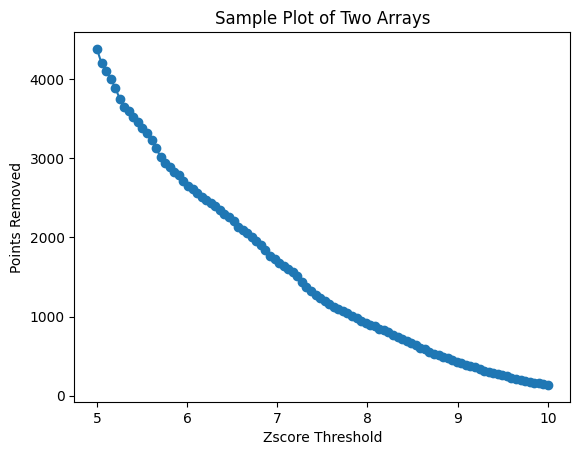

In [31]:

import matplotlib.pyplot as plt

# Sample data
x = z_thresholds # x-axis values
y = num_removed   # y-axis values

# Plot
plt.plot(x, y, marker='o')  # You can add markers or customize the line style
plt.xlabel('Zscore Threshold')
plt.ylabel('Points Removed')
plt.title('Number of Points')
plt.show()


